<a href="https://colab.research.google.com/github/iamfaham/movie-review-sentiment-analysis./blob/main/movie_review_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Review Sentiment Analysis

This notebook performs **sentiment analysis on the IMDB movie reviews dataset**, comparing the performance of a classical machine learning model (Logistic Regression) with a deep learning model (LSTM). It follows a complete NLP pipeline including:

- 📥 **Dataset acquisition** from Kaggle via `kagglehub`
- 🧹 **Data cleaning and preprocessing**: removing HTML tags, punctuation, stopwords, etc.
- 🔡 **Feature engineering**:
  - TF-IDF vectorization for Logistic Regression
  - Tokenization and padding for LSTM
- 🤖 **Model training and evaluation**:
  - Logistic Regression using scikit-learn
  - LSTM using TensorFlow/Keras
- 📊 **Performance comparison** using accuracy, confusion matrix, and classification metrics
- 📈 **Visualization** of training/validation curves for LSTM

This end-to-end notebook highlights the practical differences between traditional and neural approaches to text classification.


### Loading IMDB Dataset

This cell uses `kagglehub` to download the "IMDB Dataset of 50K Movie Reviews" from Kaggle. It prints the path to the dataset, which is later used for reading the CSV file. This setup helps automate the retrieval of a standardized dataset useful for binary sentiment classification tasks.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


### Reading Dataset into a DataFrame

The CSV file containing the IMDB dataset is read into a pandas DataFrame. The first few rows are displayed to verify that the dataset has two columns: `review` (text) and `sentiment` (label). These are essential for training a supervised text classification model.


In [4]:
import pandas as pd
df = pd.read_csv(path + "/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Text Preprocessing and Cleaning

This block cleans the raw reviews:
- Removes HTML tags
- Filters out non-letter characters
- Converts text to lowercase
- Removes stopwords using NLTK

A new column `review_clean` is created to store the cleaned text. This is a crucial step before any vectorization or model training to reduce noise and improve model quality.


In [5]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)        # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # Remove non-letters
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['review_clean'] = df['review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### TF-IDF Vectorization

The cleaned reviews are vectorized using `TfidfVectorizer`, which transforms text into numerical form while emphasizing informative words. The feature space is limited to the top 5000 words to manage dimensionality. Sentiments are converted to binary labels: 1 for positive, 0 for negative.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['review_clean']).toarray()
y = df['sentiment'].apply(lambda x: 1 if x == "positive" else 0)



### Train-Test Split for TF-IDF Features

The dataset is split into training and testing sets using an 80-20 ratio. This split is essential to train the logistic regression model and evaluate its generalization.


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Logistic Regression

### Logistic Regression Model using scikit-learn

A baseline logistic regression classifier is trained on TF-IDF features. It achieves an accuracy of ~89.2%, which is a strong result for a simple linear model on textual data. This will serve as a benchmark for the upcoming deep learning model.


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8922


## LSTM Model using Tensorflow


### Tokenization and Padding for LSTM

This block prepares inputs for an LSTM model using TensorFlow's tokenizer. It converts text into sequences of word indices and pads them to a uniform length of 200 tokens. The vocabulary is limited to 10,000 words, and unknown tokens are handled with `<OOV>`.


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize
max_vocab = 10000  # number of words to keep
max_len = 200      # maximum review length

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review_clean'])

sequences = tokenizer.texts_to_sequences(df['review_clean'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, truncating='post')

# Labels
labels = df['sentiment'].apply(lambda x: 1 if x == "positive" else 0).values


### Train-Test Split for LSTM Input

The padded sequences and corresponding sentiment labels are split into training and test sets for training the LSTM model. The same 80-20 split ensures consistency in evaluation.


In [11]:
from sklearn.model_selection import train_test_split

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)


### LSTM Model Architecture

This block defines a sequential LSTM model with:
- An Embedding layer (turns word indices into dense vectors)
- A single LSTM layer for sequence modeling
- A Dropout layer for regularization
- A Dense output layer with sigmoid for binary classification

The model is compiled with binary crossentropy loss and the Adam optimizer.


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2


model_lstm = Sequential([
    # Embedding(input_dim=max_vocab, output_dim=64, input_length=max_len),
    Embedding(input_dim=max_vocab, output_dim=64),
    Bidirectional(LSTM(12, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the LSTM Model

The LSTM model is trained for 4 epochs with a batch size of 128. It quickly improves accuracy and reaches ~92% on the training set and ~88% on validation. Slight overfitting was noticeable in later epochs(>2), as validation accuracy plateaus and loss increases.


In [63]:
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=4,
    batch_size=128,
    validation_data=(X_test_lstm, y_test_lstm)
)

Epoch 1/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 214ms/step - accuracy: 0.6736 - loss: 0.6153 - val_accuracy: 0.8579 - val_loss: 0.3938
Epoch 2/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 203ms/step - accuracy: 0.8905 - loss: 0.3460 - val_accuracy: 0.8636 - val_loss: 0.3617
Epoch 3/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 200ms/step - accuracy: 0.9170 - loss: 0.2814 - val_accuracy: 0.8769 - val_loss: 0.3410
Epoch 4/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 211ms/step - accuracy: 0.9338 - loss: 0.2473 - val_accuracy: 0.8791 - val_loss: 0.3400


### LSTM Model Evaluation

This block evaluates the trained LSTM on the test set. The final test accuracy is approximately **88%**, which is comparable to the logistic regression baseline but achieved using a more complex, sequential deep learning model.


In [64]:
loss_lstm, acc_lstm = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print("LSTM Accuracy:", acc_lstm)


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8799 - loss: 0.3401
LSTM Accuracy: 0.8791000247001648


### Training Curves Visualization

Two plots are generated:
1. **Accuracy Curve**: Compares training and validation accuracy across epochs.
2. **Loss Curve**: Compares training and validation loss across epochs.

These visualizations help assess model learning dynamics, such as convergence and overfitting. For example, divergence between training and validation performance may indicate overfitting after a certain number of epochs.


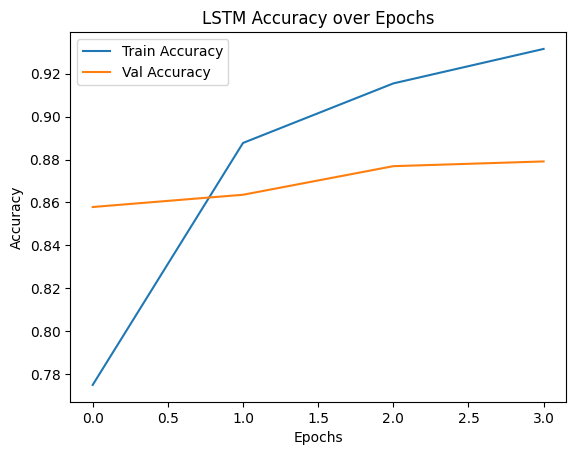

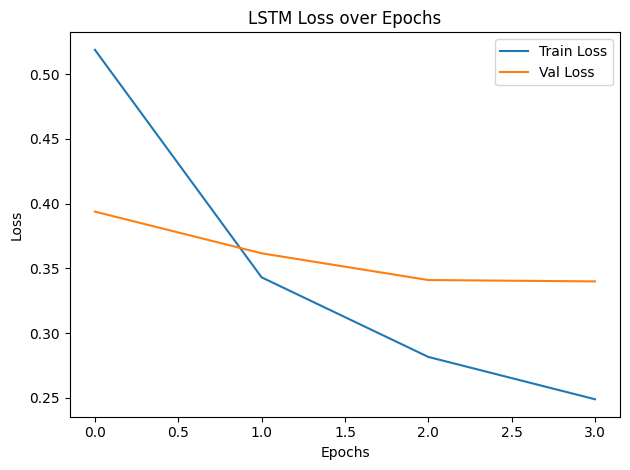

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("LSTM Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


### Confusion Matrix and Classification Metrics

This section computes the confusion matrix and classification report (precision, recall, F1-score) for the LSTM model on the test set. These metrics offer a more granular view of the model’s performance beyond accuracy, especially useful for understanding how well the model handles both sentiment classes.


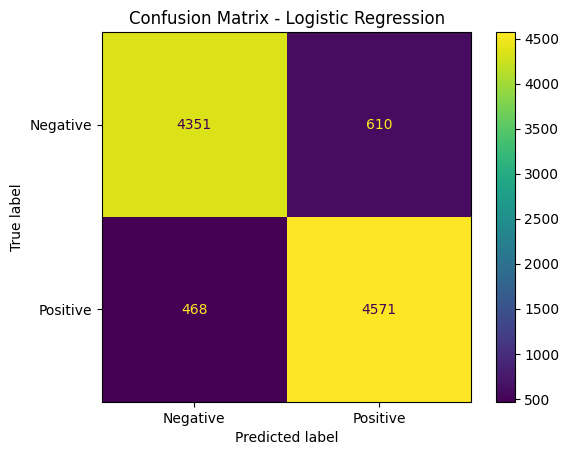

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


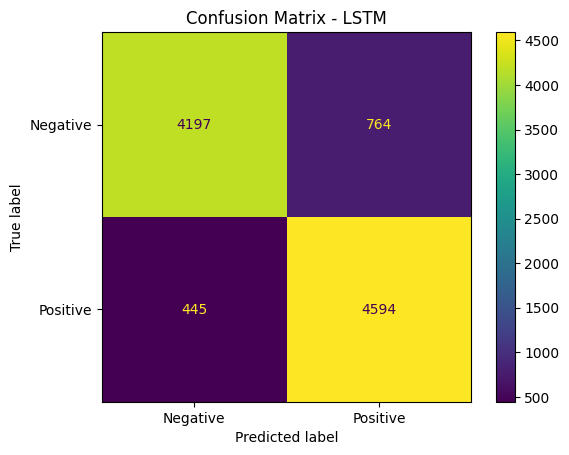

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Negative", "Positive"])
disp_lr.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# For LSTM
y_pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype(int)
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=["Negative", "Positive"])
disp_lstm.plot()
plt.title("Confusion Matrix - LSTM")
plt.show()


### Final Model Comparison

This section prints the final accuracy scores of both models — Logistic Regression and LSTM — in a more readable format. It's useful for summarizing results at the end of the notebook and drawing a conclusion about which model performs better under the current settings.



In [67]:
from sklearn.metrics import classification_report

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred))

print("LSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      4961
           1       0.86      0.91      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


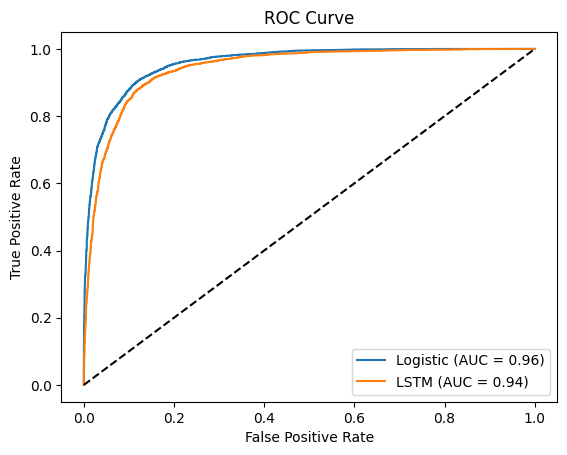

In [68]:
from sklearn.metrics import roc_curve, auc

# Logistic Regression
y_proba_lr = model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# LSTM
y_proba_lstm = model_lstm.predict(X_test_lstm)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_lstm, y_proba_lstm)
auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plotting
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC = {auc_lr:.2f})")
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {auc_lstm:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## ✅ Final Conclusion

Both models performed well on the sentiment classification task, but with some trade-offs:

- **Logistic Regression** achieved an accuracy of **~89.2%** with TF-IDF features. It is fast, interpretable, and performs surprisingly well for such a simple model.
- **LSTM**, a deep learning model trained on word sequences, reached an accuracy of **~88%**. While slightly less accurate here, LSTM models typically perform better when more data or complex patterns are present.

Despite the similar accuracy, the LSTM model may generalize better with further tuning and additional training time. However, for this dataset and scope, the logistic regression baseline proves to be highly competitive.

> 🔍 **Insight**: Simpler models can outperform or rival complex neural networks when data is well-preprocessed and the problem is linearly separable.
